# Explaining Tree Construction

In [ ]:
from __future__ import annotations
import numpy as np
import itertools
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from scipy.optimize import linprog
from typing import Dict, List, Optional, Tuple, Iterable
from scipy.optimize import linprog
import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')

## The Region

In [325]:
# Region class as dataclass
from intvalpy import lineqs
class Region:
    def __init__(self, activation=None, input_dim=None):
        # Region attributes
        self.qlw = activation # Activation pattern
        self.qlw_tilde = None # Active bits in activation pattern (indices)
        self.bounded = None
        
        # Inequalities and projections
        
        
        if input_dim is not None:
            self.Alw = np.eye(input_dim) # Slope projection matrix
            self.clw = np.zeros((input_dim, 1)) # Intercept projection matrix
            
            
            # Generate hypercube inequalities
            # Each dimension has 2 constraints (upper and lower bound)
            # D will have 2n rows and n columns
            self.Dlw  = np.zeros((2 * input_dim, input_dim))
            # g will be a vector of all 1s since |x_i| <= 1
            self.glw  = np.ones((2 * input_dim, 1))
            
            for i in range(input_dim):
                # Constraint for x_i <= 1
                self.Dlw[2 * i, i] = 1
                # Constraint for -x_i <= 1 (which is x_i >= -1)
                self.Dlw[2 * i + 1, i] = -1
            
            
            self.Dlw_active = self.Dlw # Active slopes
            self.glw_active = self.glw # Active intercepts
        else:
            self.Alw = None # Slope projection matrix
            self.clw = None # Intercept projection matrix
            
            self.Dlw = None # Slopes of inequalities
            self.glw = None # Intercept of inequalities 
            
        self.Dlw_active = None # Active slopes
        self.glw_active = None # Active intercepts
        
        # Tree attributes
        self.parent = None # Parent Region object
        self.children = [] # List of children (Region objects)
        
        # Utility attributed
        self.layer_number = 0 # Layer to which this region belongs
        self.region_index = 0 # Index to identify regions #TODO necessary?

        # Estimation attributes
        self.volume_estimate = None
        self.vertices = None
        self.sample_points = {}
        
    def add_child(self, child):
        child.parent = self
        self.children.append(child)
        
    def is_leaf(self):
        return len(self.children) == 0
    
    def is_root(self):
        return self.parent is None
    
    def get_children(self):
        return self.children
    
    def get_depth(self):
        depth = 0
        node = self
        while node.parent is not None:
            node = node.parent
            depth += 1
        assert depth == self.layer_number, "Depth and layer number are not equal"
        return depth
    
    def get_ancestors(self):
        ancestors = []
        node = self
        
        while node.parent is not None:
            ancestors.append(node.parent)
            node = node.parent
        
        return ancestors[::-1]
    
    def get_path_inequalities(self):
        D_list = []
        g_list = []
        node = self
        
        while node.parent is not None:
            D_list.append(node.Dlw_active)
            g_list.append(node.glw_active)
            node = node.parent
        
        D_path = np.vstack(D_list[::-1])
        g_path = np.vstack(g_list[::-1])
        
        return D_path, g_path
    
    
    def __str__(self):
        returnstring = f"\n--------------\nRegion info:\n--------------\nLayer: {self.layer_number}\nIndex: {self.region_index}\nLocal activation: {self.qlw}\nInput dim: {self.Alw.shape[1] if self.Alw is not None else 'N/A'}\nChildren: {len(self.children)}"
        if self.is_root():
            returnstring += "\nThis is the root region."
        elif self.is_leaf():
            returnstring += "\nThis is a leaf region."
            returnstring += f"\nAncestors: {len(self.get_ancestors())}"
        return returnstring  

## The Tree

In [ ]:
from numba import njit

# Utility functions
def get_interior_point_adaptive(A, b, initial_slack=0.1, min_threshold=1e-10, verbose=False):
    """
    Finds a point inside Ax <= b. If min_slack is too large, 
    it recursively tries with smaller slack.
    """
    m, n = A.shape
    
    # Ensure inputs are flat 1D arrays to avoid the Dimension/Shape ValueError
    b = np.asarray(b).flatten()
    norms = np.linalg.norm(A, axis=1).flatten()
    c = np.zeros(n)
    
    current_slack = initial_slack
    print(f"Searching for point...") if verbose else None
    while current_slack >= min_threshold:
        # Apply the shrinking logic
        b_shrunk = b - (current_slack * norms)
        
        # Try to solve the LP
        res = linprog(c, A_ub=A, b_ub=b_shrunk, 
                    bounds=[(None, None)] * n, 
                    method='highs')
        
        if res.success:
            print(f"Success found with slack: {current_slack}") if verbose else None
            return res.x
        
        # If infeasible, reduce slack and try again
        print(f"Slack {current_slack} too large, trying {current_slack/10}...") if verbose else None
        current_slack /= 10
        
    # Final attempt: try with zero slack (finds any point on/in the boundary)
    res_final = linprog(c, A_ub=A, b_ub=b, bounds=[(None, None)] * n, method='highs')
    if res_final.success:
        return res_final.x
        
    raise ValueError("Polytope is empty or infeasible even with zero slack.")

def find_active_indices(D_local, g_local, D_global=None, g_global=None, tol=1e-7):
    """
    Identifies which local constraints are active relative to a global domain.
    Combines constraint preparation and LP solving into a single sequential pass.
    """
    
    # TODO Move this into the solver, and have this function accept only D and g
    # --------------------------------------------------------------------------
    D_local = np.asarray(D_local)
    g_local = np.asarray(g_local).flatten()
    n_local, dim = D_local.shape
    
    # Merge local and global constraints into a unified set
    if D_global is not None and g_global is not None:
        D_all = np.vstack([D_local, np.asarray(D_global)])
        g_all = np.concatenate([g_local, np.asarray(g_global).flatten()])
    else:
        D_all, g_all = D_local, g_local
    # --------------------------------------------------------------------------
    
    bounds = [(None, None)] * dim
    active_local_bits = []
    is_bounded = True

    # Iterate through local constraints ONLY
    for i in range(n_local):
        d_i = D_all[i]
        
        # Define the feasible region using all constraints EXCEPT the one we are testing
        D_tilde = np.delete(D_all, i, axis=0)
        g_tilde = np.delete(g_all, i, axis=0)

        try:
            res = linprog(
                c=-d_i, # Maximize distance along the normal of constraint i
                A_ub=D_tilde,
                b_ub=g_tilde,
                bounds=bounds,
                method="highs",
            )
            
            if res.success:
                # Calculate the objective value manually if res.fun is ambiguous
                val = -res.fun if res.fun is not None else np.dot(d_i, res.x)
                
                # If we can push past the boundary, it's a "redundant" or reachable bit
                if val > g_all[i] + tol:
                    active_local_bits.append(i)
            
            elif res.status == 3: # Unbounded: we can go to infinity past this boundary
                active_local_bits.append(i)
                is_bounded = False

        except ValueError as e:
            # Handle specific HiGHS internal status 15 if encountered
            if "HiGHS Status 15" in str(e):
                active_local_bits.append(i)
                is_bounded = False
            else:
                raise e

    return np.array(sorted(active_local_bits)), is_bounded

def find_activation_pattern(x, Wl, bl, Alw_prev, clw_prev):
    z = Wl @ Alw_prev @ x + Wl @ clw_prev + bl
    return (z>0).astype(int)

def to_tuple(array):
    return tuple(array.ravel())

# Hyperplane extraction from state_dict
def find_hyperplanes(state_dict):
    weights = []
    biases = []
    hyperplanes = [] 
    for key, val in state_dict.items():
        if "weight" in key:
            weights.append(val)
        elif "bias" in key:
            biases.append(val)
    for W, b in zip(weights, biases):
        hyperplanes.append(np.hstack((W, b.reshape(-1,1))))
    return hyperplanes

# def calculate_next_layer_quantities(Wl, bl, qlw, Alw_prev, clw_prev):
#     #Old way
#     Slw = np.diag((-2*qlw +1).ravel())
#     Qlw = np.diag(qlw.ravel())
    
#     Wl_hat = np.matmul(Wl, Alw_prev)
#     bl_hat = np.matmul(Wl, clw_prev) + bl
    
#     Dlw = np.matmul(Slw, Wl_hat)
#     glw = -np.matmul(Slw, bl_hat)
    
#     Alw = np.matmul(Qlw, Wl_hat)
#     clw = np.matmul(Qlw, bl_hat)

#     return Dlw, glw, Alw, clw



@njit(cache=True, fastmath=True)
def _jit_core_logic(Wl, bl, qlw, Alw_prev, clw_prev):
    # We cast to float64 inside JIT to ensure mathematical consistency
    qlw_f = qlw.astype(np.float64).reshape(-1, 1)
    bl_2d = bl.reshape(-1, 1).astype(np.float64)
    clw_prev_2d = clw_prev.reshape(-1, 1).astype(np.float64)

    # Combined matmul for speed
    combined_prev = np.column_stack((Alw_prev, clw_prev_2d))
    combined_hat = Wl @ combined_prev
    
    Wl_hat = combined_hat[:, :-1]
    bl_hat = combined_hat[:, -1:] + bl_2d

    s_vec = -2.0 * qlw_f + 1.0
    
    # This is where your shape error happens: 
    # s_vec (from qlw) must match Wl_hat (from Wl rows)
    Dlw = s_vec * Wl_hat
    glw = -(s_vec * bl_hat)
    
    Alw = qlw_f * Wl_hat
    clw = (qlw_f * bl_hat)

    return Dlw, glw, Alw, clw

def calculate_next_layer_quantities(Wl, bl, qlw, Alw_prev, clw_prev):
    # --- DIMENSION SAFETY CHECK ---
    # qlw (bitstring) length must match Wl output (rows)
    if len(qlw) != Wl.shape[0]:
        raise ValueError(f"Dimension Mismatch! Activation qlw has {len(qlw)} bits, "
                         f"but Wl produces {Wl.shape[0]} outputs. "
                         f"Are you using the Wl from the wrong layer?")
    
    # Ensure inputs are numpy arrays
    return _jit_core_logic(
        np.asarray(Wl, dtype=np.float64), 
        np.asarray(bl, dtype=np.float64), 
        np.asarray(qlw, dtype=np.float64), 
        np.asarray(Alw_prev, dtype=np.float64), 
        np.asarray(clw_prev, dtype=np.float64)
    )

def find_next_layer_region_info(Dlw_active_prev, glw_active_prev, Alw_prev, clw_prev, Wl, bl, layer_nr, verbose=False):    
    
    # Random point within region
    if layer_nr != 1:
        x = get_interior_point_adaptive(Dlw_active_prev, glw_active_prev).reshape(-1,1)
    else:
        x = np.random.random((2,1)).reshape(-1,1)
    
    # print(f"{Wl.shape} @ {Alw_prev.shape} @ {x.shape} + {Wl.shape} @ {clw_prev.shape} + {bl.shape}")
    # Get activation of random point
    z = Wl @ Alw_prev @ x + Wl @ clw_prev + bl
    q0 = (z>0).astype(int)
    
  
    traversed = {}
    queue = [tuple(q0.ravel())]
    while queue:
        q = queue.pop(0) # Get next activation
        qlw = np.array(q)
        
        Dlw, glw, Alw, clw = calculate_next_layer_quantities(Wl, bl, qlw, Alw_prev, clw_prev)
        
        qi_act, is_bounded = find_active_indices(Dlw, glw, Dlw_active_prev, glw_active_prev)
        
        
        for i_act in qi_act:
            q_new = qlw.copy()
            q_new[i_act] ^= 1
            new_key = tuple(q_new.ravel())
            
            if new_key not in traversed:
                traversed[new_key] = False
                queue.append(new_key)
                
        traversed[q] = {
            "q_tilde": qi_act,
            "bounded": is_bounded,
            "Dlw": Dlw,
            "glw": glw,
            "Alw": Alw,
            "clw": clw,
        }
    return traversed
    
    

In [327]:
# Old Tree
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
class OldTree:
    def __init__(self, state_dict):
        # Find the hyperplanes from the state dict
        self.hp = self._find_hyperplanes(state_dict)
        self.input_dim = self.hp[0].shape[1] - 1  # Assuming all hyperplanes have the same input dimension
        self.L = len(self.hp)  # Number of layers
        
        # Initialize the root region
        self.root = Region(input_dim = self.input_dim)

    # ----------------------------------------------------------------------
    # External methods
    # ----------------------------------------------------------------------

    # Tree construction
    def construct_tree(self, verbose=False):
        current_layer_nodes = [self.root]
        
        for i, local_hp in enumerate(self.hp):
            
            # Get local layer parameters
            Wl = local_hp[:,:-1] # Local weights
            bl = local_hp[:,-1].reshape(-1,1) # Local biases
            layer = i+1 # local layer number
            
            next_layer_nodes = []
            for node in tqdm(current_layer_nodes, desc=f"Processing layer {layer}", leave=False) if verbose else current_layer_nodes:
                # 1. Find subregions for the current node
                
                #TODO Check if parallelizable
                self._find_subregions(node, layer, Wl, bl, verbose=False)
                
                # 2. Add children to next layer nodes
                next_layer_nodes.extend(node.get_children())
                
            current_layer_nodes = next_layer_nodes
            # Optional: Break if there are no more children to process
            if not current_layer_nodes:
                break
            
    # ----------------------------------------------------------------------
    # Multiprocessing parallelization
    # ----------------------------------------------------------------------

    # Tree construction
    def construct_tree_parallel(self, n_jobs=None, verbose=False):
        current_layer_nodes = [self.root]
        
        for i, local_hp in enumerate(self.hp):
            
            # Get local layer parameters
            Wl = local_hp[:,:-1] # Local weights
            bl = local_hp[:,-1].reshape(-1,1) # Local biases
            layer = i+1 # local layer number
            
            next_layer_nodes = []
            
            tasks = [(node, layer, Wl, bl) for node in current_layer_nodes]
            
            if n_jobs is None:
                n_jobs = mp.cpu_counts()
                
            with mp.Pool(processes=n_jobs) as pool:
                for node in pool.imap_unordered(self._one_job, tasks):
        
                    # 2. Add children to next layer nodes
                    next_layer_nodes.extend(node.get_children())
                
            current_layer_nodes = next_layer_nodes
            # Optional: Break if there are no more children to process
            if not current_layer_nodes:
                break

    def _one_job(self, args):
        node, layer, Wl, bl = args
        self._find_subregions(node, layer, Wl, bl, verbose=False)
        return node
    
    # ----------------------------------------------------------------------
    # Multithreading parallelization
    # ----------------------------------------------------------------------

    def construct_tree_threaded(self, max_workers=None, verbose=False):
        current_layer_nodes = [self.root]
    
        # 1. Open the pool once for the entire construction process
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for i, local_hp in enumerate(self.hp):
                Wl = local_hp[:, :-1]
                bl = local_hp[:, -1].reshape(-1, 1)
                layer = i + 1
                
                # 2. Map the work for the current layer
                # Since threads share memory, 'node' is modified in place
                list(executor.map(lambda n: self._find_subregions(n, layer, Wl, bl, False), current_layer_nodes))
                
                # 3. Collect children for the next layer
                next_layer_nodes = []
                for node in current_layer_nodes:
                    next_layer_nodes.extend(node.get_children())
                
                current_layer_nodes = next_layer_nodes
                if not current_layer_nodes:
                    break

    # ----------------------------------------------------------------------
    # Get-methods
    # ----------------------------------------------------------------------

    def get_regions_at_layer(self, layer: int):
        regions = []
        queue = [self.root]
        
        while queue:
            current_region = queue.pop(0)
            
            if current_region.layer_number == layer:
                regions.append(current_region)
            elif current_region.layer_number < layer:
                queue.extend(current_region.get_children())
        return regions



    # ----------------------------------------------------------------------
    # Internal methods
    # ----------------------------------------------------------------------
    
    # Hyperplane extraction from state_dict
    def _find_hyperplanes(self, state_dict):
        weights = []
        biases = []
        hyperplanes = [] 
        for key, val in state_dict.items():
            if "weight" in key:
                weights.append(val)
            elif "bias" in key:
                biases.append(val)
        for W, b in zip(weights, biases):
            hyperplanes.append(np.hstack((W, b.reshape(-1,1))))
        return hyperplanes
    
    def _find_subregions(self, parent, layer, Wl, bl, verbose=False):
        # Find point
        x = self._get_interior_point_adaptive(parent, verbose=verbose).reshape(-1,1)
        
        # Global contraints
        D_global = parent.Dlw_active
        g_global = parent.glw_active
        
        # Check layer numbering
        assert layer == parent.layer_number +1
        
        # Find activation of point
        q0 = self._find_activation_pattern(x, Wl, bl, parent.Alw, parent.clw)
        
        # 1. Initialize
        traversed = {}
        actives = {} # Dictionary with indices of active neurons for each activation
        queue = [self._to_tuple(q0)]
        # traversed[to_tuple(q0)] = True
        # 2. Process until no new states are found
        region_idx = 0
        while queue:
            current_key = queue.pop(0)  # Get the next state to process
            current_q = np.array(current_key) 
            
            # Calculate relevant quantities
            # Slw = get_sign_matrix(current_q)
            
            # Get sign vector
            slw = -2 * current_q + 1
            # Get sign matrix
            Slw = np.diag(slw.ravel())
            
            # Find local inequalities
            local_hyperplane_slopes = Wl @ parent.Alw
            local_hyperplane_intercepts = Wl @ parent.clw + bl
            Dlw = Slw @ local_hyperplane_slopes
            glw = - Slw @ local_hyperplane_intercepts
            
            
            # Find active indices
            if layer == 1:
                local_active_indices, is_bounded = self._find_active_bits(Dlw, glw) 
            else:
                local_active_indices, is_bounded = self._find_active_bits(Dlw, glw, D_global, g_global) 
            actives[current_key] = local_active_indices
            
            # Initialize new region
            new_region = Region(current_q)
            new_region.q_tilde = local_active_indices
            new_region.bounded = is_bounded
            new_region.Dlw = Dlw
            new_region.glw = glw
            new_region.Dlw_active = Dlw[list(local_active_indices),:]
            new_region.glw_active = glw[list(local_active_indices)]
            # new_region.find_active_inequalities()
            
            # Compute projections for that region
            Qlw = np.diag(current_q.ravel())
            new_region.Alw = Qlw @ local_hyperplane_slopes
            new_region.clw = Qlw @ local_hyperplane_intercepts
            
            # Place region in region tree
            new_region.layer_number = layer
            new_region.region_index = region_idx
            region_idx += 1
            parent.add_child(new_region)
            
            traversed[current_key] = True
            
            for active_idx in local_active_indices:
                # Generate neighbor
                q_new = current_q.copy()
                q_new[active_idx] ^= 1
                new_key = self._to_tuple(q_new)
                
                # 3. Only add if we haven't seen it before
                if new_key not in traversed:
                    traversed[new_key] = False
                    queue.append(new_key)  # Add to queue to be processed in a future loop
                    
            # Mark the current one as fully processed
            traversed[current_key] = True
            
    
    def _solve_single_lp(self, args):
        """
        Tests if a SPECIFIC local constraint i is active GIVEN the global domain.
        """
        target_idx, D_all, g_all, tol, bounds = args
        
        # The direction we want to push to see if we can "cross" this boundary
        d_i = D_all[target_idx]
        
        # We must satisfy ALL constraints EXCEPT the one we are testing
        D_tilde = np.delete(D_all, target_idx, axis=0)
        g_tilde = np.delete(g_all, target_idx, axis=0)

        try:
            res = linprog(
                c=-d_i, # Maximize distance past the boundary
                A_ub=D_tilde,
                b_ub=g_tilde,
                bounds=bounds,
                method="highs",
            )
        except ValueError as e:
            if "HiGHS Status 15" in str(e):
                return target_idx, False 
            raise e

        if res.x is not None:
            val = -res.fun if res.fun is not None else np.dot(d_i, res.x)
            # If we can cross the boundary (val > g[i]), the neighbor is reachable
            if val > g_all[target_idx] + tol:
                return target_idx, True
            return -1, True
        
        elif res.status == 3: # Unbounded past the boundary
            return target_idx, False
        
        return -1, True

    def _find_active_bits(self, D_local, g_local, D_global=None, g_global=None, tol=1e-7):
        """
        Only solves LPs for local constraints, but uses global constraints as bounds.
        """
        D_local = np.asarray(D_local)
        g_local = np.asarray(g_local).flatten()
        
        n_local = D_local.shape[0]
        dim = D_local.shape[1]
        
        # Combine everything for the background constraints if there are any
        if D_global is not None and g_global is not None:
            D_global = np.asarray(D_global)
            g_global = np.asarray(g_global).flatten()
            D_all = np.vstack([D_local, D_global])
            g_all = np.concatenate([g_local, g_global])
        else: # If no global constraints, just use local
            D_all = D_local
            g_all = g_local
        
        bounds = [(None, None)] * dim
        active_local_bits = []
        is_bounded = True
        
        # Only create tasks for the LOCAL indices (0 to n_local - 1)
        tasks = [(i, D_all, g_all, tol, bounds) for i in range(n_local)]
        
 
        for task in tasks:
            idx, bounded = self._solve_single_lp(task)
            if idx != -1:
                active_local_bits.append(idx)
            if not bounded:
                is_bounded = False
                    
        return np.array(sorted(active_local_bits)), is_bounded
          
    def _get_interior_point_adaptive(self, region, initial_slack=0.1, min_threshold=1e-10, verbose=False):
        """
        Finds a point inside Ax <= b. If min_slack is too large, 
        it recursively tries with smaller slack.
        """
        A = region.Dlw_active
        b = region.glw_active
        if A is None or b is None:
            A = region.Dlw
            b = region.glw
        
        m, n = A.shape
        
        # Ensure inputs are flat 1D arrays to avoid the Dimension/Shape ValueError
        b = np.asarray(b).flatten()
        norms = np.linalg.norm(A, axis=1).flatten()
        c = np.zeros(n)
        
        current_slack = initial_slack
        print(f"Searching for point...") if verbose else None
        while current_slack >= min_threshold:
            # Apply the shrinking logic
            b_shrunk = b - (current_slack * norms)
            
            # Try to solve the LP
            res = linprog(c, A_ub=A, b_ub=b_shrunk, 
                        bounds=[(None, None)] * n, 
                        method='highs')
            
            if res.success:
                print(f"Success found with slack: {current_slack}") if verbose else None
                return res.x
            
            # If infeasible, reduce slack and try again
            print(f"Slack {current_slack} too large, trying {current_slack/10}...") if verbose else None
            current_slack /= 10
            
        # Final attempt: try with zero slack (finds any point on/in the boundary)
        res_final = linprog(c, A_ub=A, b_ub=b, bounds=[(None, None)] * n, method='highs')
        if res_final.success:
            return res_final.x
            
        raise ValueError("Polytope is empty or infeasible even with zero slack.")


    def _find_activation_pattern(self, x, Wl, bl, Alw_prev, clw_prev):
        z = Wl @ Alw_prev @ x + Wl @ clw_prev + bl
        return (z>0).astype(int)

    def _to_tuple(self, array):
        return tuple(array.ravel())
    
    def some():
        pass

In [328]:
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
class Tree:
    def __init__(self, state_dict):
        # Find the hyperplanes from the state dict
        self.hp = find_hyperplanes(state_dict)
        self.input_dim = self.hp[0].shape[1] - 1  # Assuming all hyperplanes have the same input dimension
        self.L = len(self.hp)  # Number of layers
        
        # Initialize the root region
        self.root = Region(input_dim = self.input_dim)

    # ----------------------------------------------------------------------
    # External methods
    # ----------------------------------------------------------------------

    # Tree construction
    def construct_tree(self, verbose=False):
        current_layer_nodes = [self.root]
        
        for i, local_hp in enumerate(self.hp):
            
            # Get local layer parameters
            Wl = local_hp[:,:-1] # Local weights
            bl = local_hp[:,-1].reshape(-1,1) # Local biases
            layer = i+1 # local layer number
            
            next_layer_nodes = []
            for parent in tqdm(current_layer_nodes, desc=f"Processing layer {layer}", leave=False) if verbose else current_layer_nodes:
                # print(parent.layer_number, layer)
                assert parent.layer_number == layer - 1
                
                new_nodes_info = find_next_layer_region_info(parent.Dlw_active, parent.glw_active, parent.Alw, parent.clw, Wl, bl, layer)
                
                for act, info in new_nodes_info.items():
                    child = Region(np.array(act))
                    child.q_tilde = info["q_tilde"]
                    child.bounded = info["bounded"]
                    child.Dlw = info["Dlw"]
                    child.glw = info["glw"]
                    child.Dlw_active = info["Dlw"][list(info["q_tilde"])]
                    child.glw_active = info["glw"][list(info["q_tilde"])]
                    child.Alw = info["Alw"]
                    child.clw = info["clw"]
                    child.layer_number = layer
                    parent.add_child(child)
                    next_layer_nodes.append(child)
                          
            current_layer_nodes = next_layer_nodes
            # Optional: Break if there are no more children to process
            if not current_layer_nodes:
                break
            

    # ----------------------------------------------------------------------
    # Get-methods
    # ----------------------------------------------------------------------

    def get_regions_at_layer(self, layer: int):
        regions = []
        queue = [self.root]
        
        while queue:
            current_region = queue.pop(0)
            
            if current_region.layer_number == layer:
                regions.append(current_region)
            elif current_region.layer_number < layer:
                queue.extend(current_region.get_children())
        return regions



    # ----------------------------------------------------------------------
    # Internal methods
    # ----------------------------------------------------------------------
    

            




## Is it working?

### Data

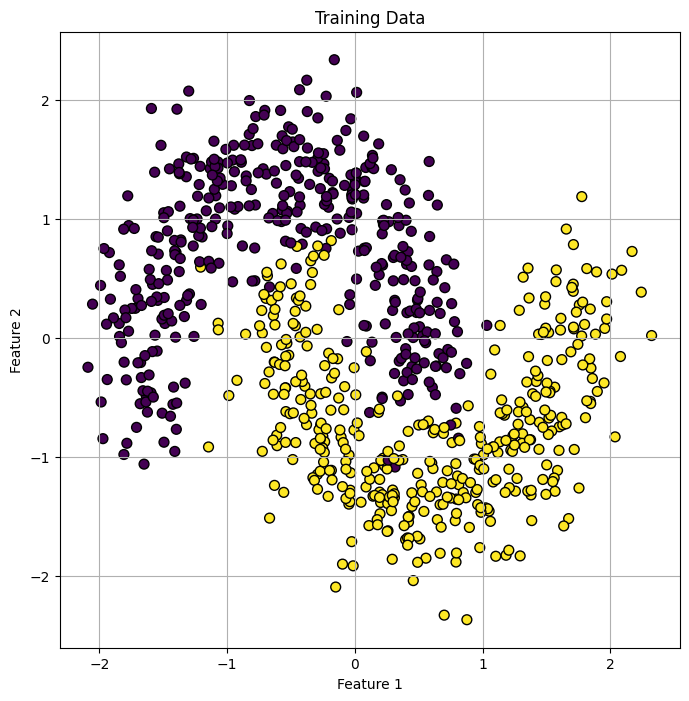

In [329]:
from src_experiment import get_moons_data, train_model, NeuralNet
train, test = get_moons_data(feature_noise=0.2)
all_features = []
all_labels = []

for features, labels in train:
    all_features.append(features.detach().cpu())
    all_labels.append(labels.detach().cpu())

# Combine batches into one large array
import torch
X = torch.cat(all_features, dim=0).numpy()
y = torch.cat(all_labels, dim=0).numpy()

plt.figure(figsize=(8,8))

# 3. Plot using the first two columns (dimensions) of the features
# X[:, 0] is Feature 1, X[:, 1] is Feature 2
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)

plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

### Model

Training not saved.


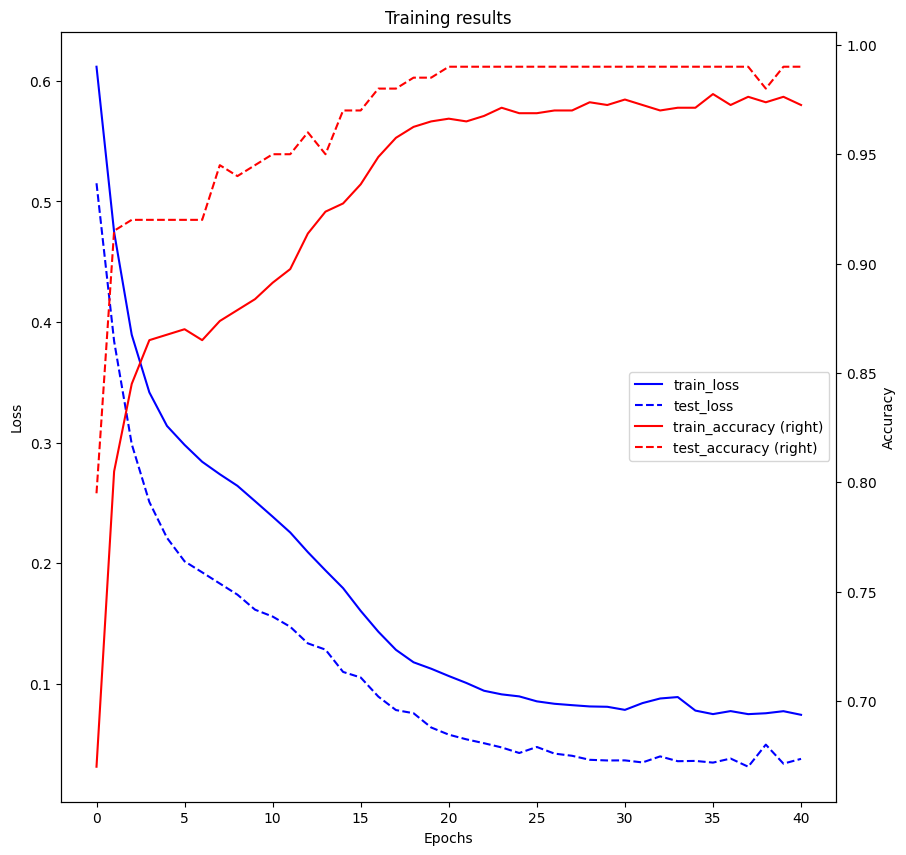

In [330]:
from visualization import plot_training
hidden_sizes = [0,10,10,10]

ActNet = NeuralNet(
    input_size = 2,
    hidden_sizes = hidden_sizes[1:],
    num_classes=1,
    seed=3,
)

res, states = train_model(ActNet, train, test, epochs=41, save_everyth_epoch=10, RETURN_STATES=True)
plot_training(res)

### Build tree (original)

In [331]:
import time
trees = {}
tot_start = time.time()
for epoch, state in states.items():
    start = time.time()
    print(f"\n--- Epoch {epoch} ---")
    tree = OldTree(state)
    tree.construct_tree(verbose=True)
    trees[epoch] = tree
    end = time.time()
    print(f"Duration: {end-start:.2f} s")
tot_end = time.time()
print(f"Total duration: {tot_end-tot_start:.2f} s")


--- Epoch 0 ---


Duration: 40.99 s

--- Epoch 10 ---


Duration: 46.36 s

--- Epoch 20 ---


Duration: 47.51 s

--- Epoch 30 ---


Duration: 48.37 s

--- Epoch 40 ---


Duration: 49.00 s
Total duration: 232.24 s


### Re-structured tree

In [332]:
import time
trees = {}
tot_start = time.time()
for epoch, state in states.items():
    start = time.time()
    print(f"\n--- Epoch {epoch} ---")
    tree = Tree(state)
    tree.construct_tree(verbose=True)
    trees[epoch] = tree
    end = time.time()
    print(f"Duration: {end-start:.2f} s")
tot_end = time.time()
print(f"Total duration: {tot_end-tot_start:.2f} s")


--- Epoch 0 ---


Duration: 41.36 s

--- Epoch 10 ---


Duration: 46.46 s

--- Epoch 20 ---


Duration: 46.95 s

--- Epoch 30 ---


Duration: 48.40 s

--- Epoch 40 ---


Duration: 48.41 s
Total duration: 231.59 s


### Parallelization attempt

In [333]:
import time
trees_p = {}
tot_start = time.time()
for epoch, state in states.items():
    start = time.time()
    print(f"\n--- Epoch {epoch} ---")
    tree = OldTree(state)
    tree.construct_tree_threaded(max_workers=25, verbose=True)
    trees_p[epoch] = tree
    end = time.time()
    print(f"Duration: {end-start:.2f} s")
tot_end = time.time()
print(f"Total duration: {tot_end-tot_start:.2f} s")


--- Epoch 0 ---
Duration: 61.87 s

--- Epoch 10 ---
Duration: 69.37 s

--- Epoch 20 ---
Duration: 69.58 s

--- Epoch 30 ---
Duration: 71.13 s

--- Epoch 40 ---
Duration: 72.19 s
Total duration: 344.14 s


In [334]:
trees_p[0].get_regions_at_layer(1)

### Visualize the tree

In [335]:
def find_vertices_from_regions(regions, bound=10):
    vertices_list = []
    for region in regions:
        # if region.layer_number == 1:
        #     D = region.Dlw_active
        #     g = region.glw_active
        # else:
        #     D = np.vstack([region.Dlw_active, region.parent.Dlw_active])
        #     g = np.vstack([region.glw_active, region.parent.glw_active])
        D, g = region.get_path_inequalities()
        
        try:
            # Use a small tolerance or check feasibility first
            verts = lineqs(-D, -g, bounds=[[-bound,-bound], [bound,bound]], show=False, size=(5,5))
            vertices_list.append(verts)
        except (IndexError, ValueError) as e:
            # print(D, g)
            print("Warning: Polytope has no vertices or is empty. Skipping visualization.")
            continue
    return vertices_list

In [336]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def plot_epoch_layer_grid(trees,  bound=50):
    epochs = sorted(trees.keys())
    num_epochs = len(epochs)
    num_layers = trees[0].L
    # 1. Setup the figure: Rows = Layers, Cols = Epochs
    fig, axes = plt.subplots(num_layers, num_epochs, 
                             figsize=(num_epochs * 3, num_layers * 3), 
                             constrained_layout=True)
    
    # Standardize axes to a 2D array for consistent indexing [row, col]
    if num_layers == 1 and num_epochs == 1:
        axes = np.array([[axes]])
    elif num_layers == 1:
        axes = axes[np.newaxis, :]
    elif num_epochs == 1:
        axes = axes[:, np.newaxis]

    # 2. Iterate through Epochs (Columns)
    for col, epoch in enumerate(epochs):
        tree = trees[epoch]
        
        # 3. Iterate through Layers (Rows)
        for row in range(num_layers):
            layer_idx = row + 1
            ax = axes[row, col]
            
            # Access existing regions at this specific layer for this specific root
            regions = tree.get_regions_at_layer(layer=layer_idx)
            
            vertices_list = find_vertices_from_regions(regions, bound=20000)
            
            # 4. Draw Polygons
            for vert in vertices_list:
                # Basic boundary check for the 2D slice
                within_boundaries = any(-bound <= coord[0] <= bound and 
                                        -bound <= coord[1] <= bound for coord in vert)
                
                if within_boundaries:
                    # Plot the polygon
                    poly = Polygon(xy=vert, 
                                   facecolor=np.random.rand(3,), 
                                   edgecolor="black", 
                                   alpha=0.6, 
                                   linewidth=0.5)
                    ax.add_patch(poly)

            # Formatting each subplot
            ax.set_xlim([-bound, bound])
            ax.set_ylim([-bound, bound])
            ax.set_aspect('equal')
            
            # Labels: Epochs on top, Layers on the left
            if row == 0:
                ax.set_title(f"Epoch {epoch}", fontsize=14, fontweight='bold')
            if col == 0:
                ax.set_ylabel(f"Layer {layer_idx}", fontsize=14, fontweight='bold')
            
            # Remove tick clutter for inner plots
            if row < num_layers - 1:
                ax.set_xticks([])
            if col > 0:
                ax.set_yticks([])

    return fig, axes


(<Figure size 1500x1200 with 20 Axes>,
 array([[<Axes: title={'center': 'Epoch 0'}, ylabel='Layer 1'>,
         <Axes: title={'center': 'Epoch 10'}>,
         <Axes: title={'center': 'Epoch 20'}>,
         <Axes: title={'center': 'Epoch 30'}>,
         <Axes: title={'center': 'Epoch 40'}>],
        [<Axes: ylabel='Layer 2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Layer 4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

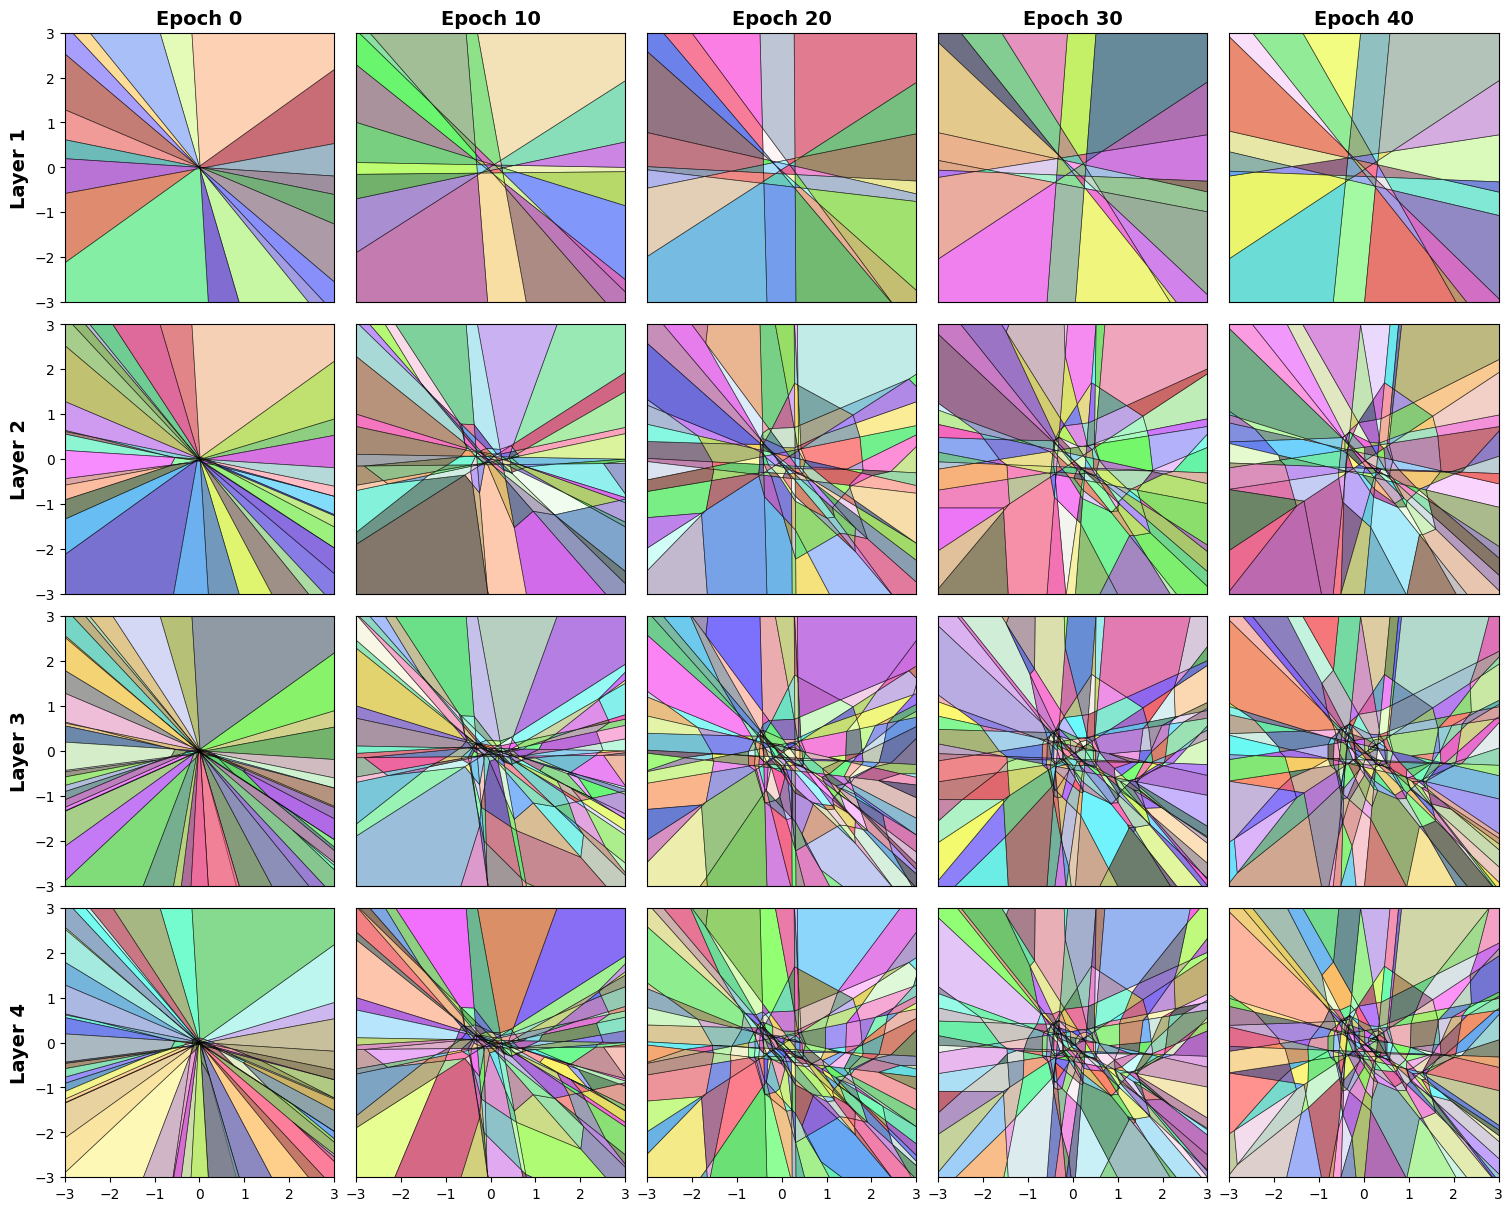

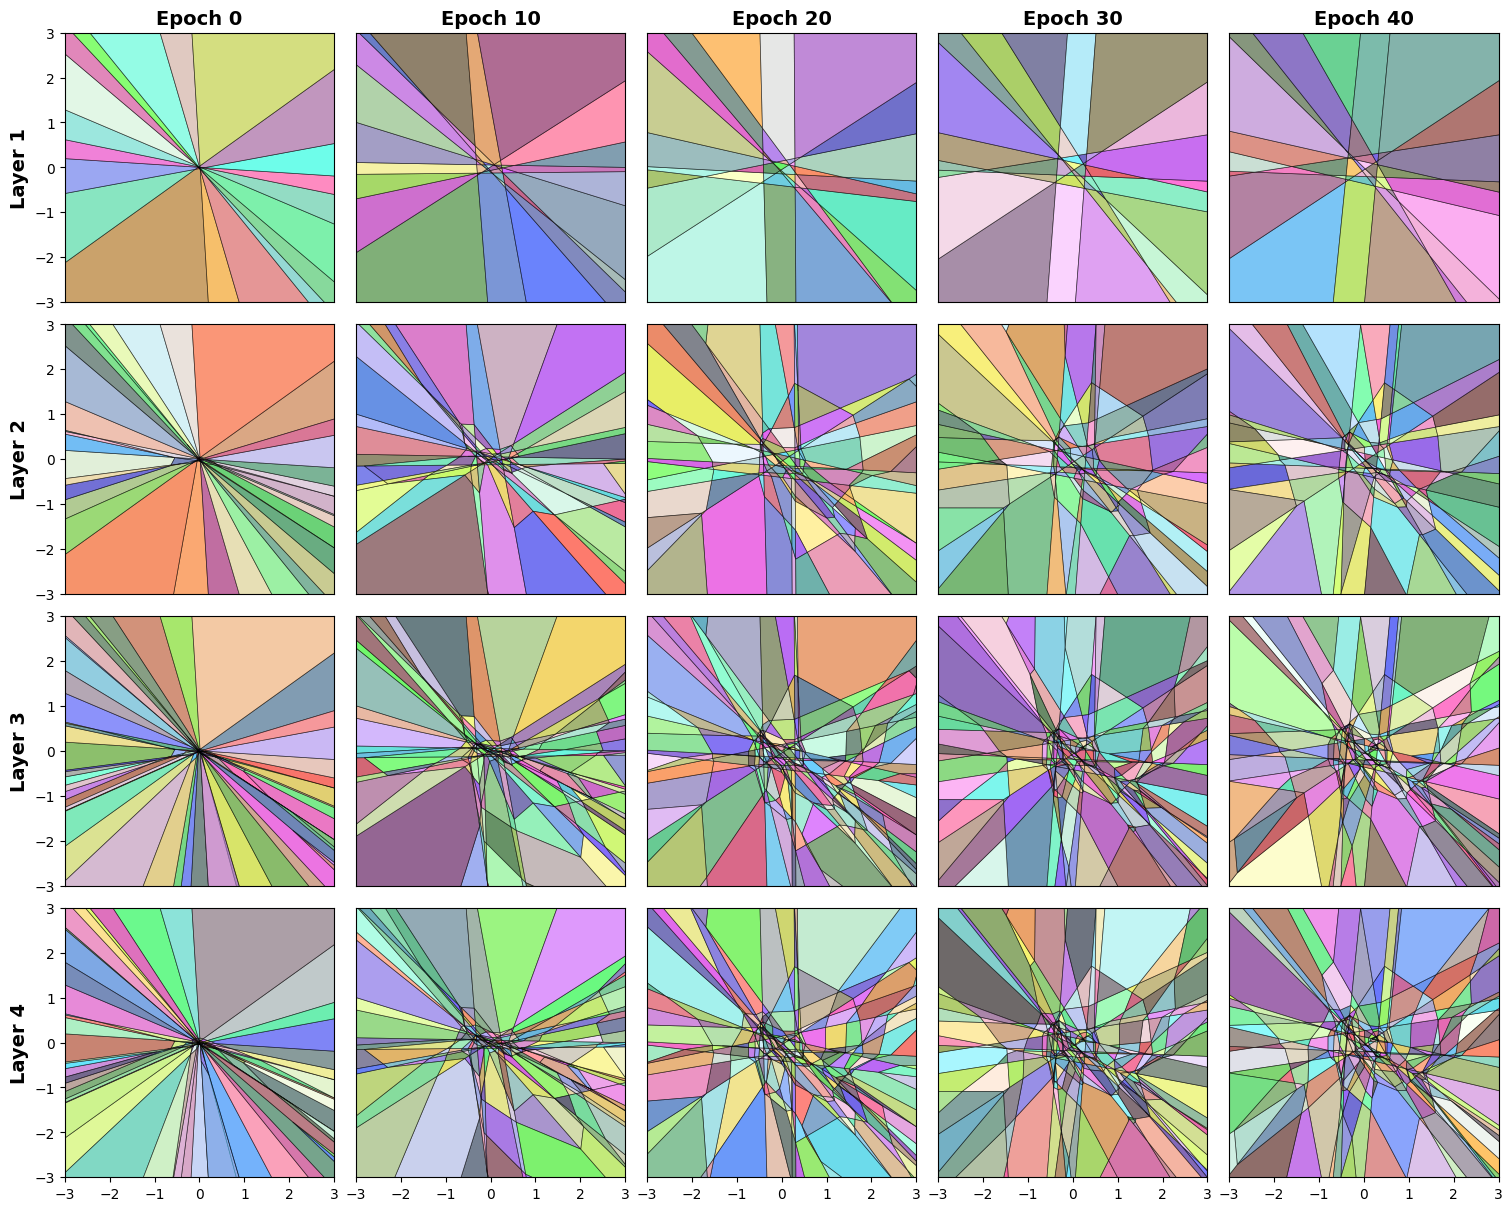

In [337]:
plot_epoch_layer_grid(trees, bound=3)
plot_epoch_layer_grid(trees_p, bound=3)